# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [12]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [13]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [14]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [15]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [59]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/4, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/4, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [27]:
def oversampling(data):
    um_train = data[1][0]
    um_validation = data[1][1]
#     print (um_train, um_validation, data[1][2])
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
#     for i, grupo in enumerate(grupos):
#         for j, g in enumerate(grupos[i]):
#             grupos[i][j] = grupos[i][j].iloc[:,:].values
#             if len(grupos[i][j]) < tam_grupo:
#                 grupos[i][j] = np.concatenate((grupos[i][j],grupos[i][j]), axis=0)
#             grupos[i][j] = grupos[i][j][:tam_grupo]
    
    return [data[0],(um_train, um_validation, data[1][2])]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [34]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [60]:
# data_set_oversampling = oversampling(separar_grupos_tvt(separar_classes(data_set)))
# print (data_set_oversampling)
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
over = oversampling(grupos)
print (len(over[0][0]), len(over[0][1]), len(over[0][2]), 
       len(over[1][0]), len(over[1][1]), len(over[1][2]))

join_c = join_class(over)
print (len(join_c[0]), len(join_c[1]), len(join_c[2]))

7592 253
5694 949 949 189 32 32
5694 949 949 5694 949 32
11388 1898 981


### Separando entrada de saida

In [61]:
# columns = data_set.columns.tolist()
# shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
# rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
X_train = join_c[0][:,:-1]
y_train = join_c[0][:,-1]

X_validation = join_c[1][:,:-1]
y_validation = join_c[1][:,-1]

X_test = join_c[2][:,:-1]
y_test = join_c[2][:,-1]
# print (y_validation)


# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 5694, 1.0: 5694})
Counter({1.0: 949, 0.0: 949})
Counter({0.0: 949, 1.0: 32})


### Normalização dos dados

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [66]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(3, activation='relu', input_dim=6))


# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='relu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train,
                         epochs=100, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 11388 samples, validate on 1898 samples
Epoch 1/100
11388/11388 [==============================] - 0s - loss: 0.2191 - acc: 0.7187 - val_loss: 0.1097 - val_acc: 0.8820
Epoch 2/100
11388/11388 [==============================] - 0s - loss: 0.1157 - acc: 0.8543 - val_loss: 0.0818 - val_acc: 0.8878
Epoch 3/100
11388/11388 [==============================] - 0s - loss: 0.1016 - acc: 0.8757 - val_loss: 0.0716 - val_acc: 0.8946
Epoch 4/100
11388/11388 [==============================] - 0s - loss: 0.0959 - acc: 0.8866 - val_loss: 0.0658 - val_acc: 0.9036
Epoch 5/100
11388/11388 [==============================] - 0s - loss: 0.0925 - acc: 0.8946 - val_loss: 0.0590 - val_acc: 0.9031
Epoch 6/100
11388/11388 [==============================] - 0s - loss: 0.0904 - acc: 0.8954 - val_loss: 0.0567 - val_acc: 0.9194
Epoch 7/100
11388/11388 [==============================] - 0s - loss: 0.0890 - acc: 0.8987 - val_loss: 0.0534 - val_acc: 0.9220
Epoch 8/100
11388/11388 [==============================

11388/11388 [==============================] - 0s - loss: 0.0776 - acc: 0.9061 - val_loss: 0.0498 - val_acc: 0.9594
Epoch 65/100
11388/11388 [==============================] - 0s - loss: 0.0775 - acc: 0.9066 - val_loss: 0.0501 - val_acc: 0.9568
Epoch 66/100
11388/11388 [==============================] - 0s - loss: 0.0773 - acc: 0.9066 - val_loss: 0.0508 - val_acc: 0.9568
Epoch 67/100
11388/11388 [==============================] - 0s - loss: 0.0772 - acc: 0.9075 - val_loss: 0.0492 - val_acc: 0.9557
Epoch 68/100
11388/11388 [==============================] - 0s - loss: 0.0772 - acc: 0.9062 - val_loss: 0.0499 - val_acc: 0.9579
Epoch 69/100
11388/11388 [==============================] - 0s - loss: 0.0770 - acc: 0.9069 - val_loss: 0.0491 - val_acc: 0.9584
Epoch 70/100
11388/11388 [==============================] - 0s - loss: 0.0770 - acc: 0.9076 - val_loss: 0.0500 - val_acc: 0.9547
Epoch 71/100
11388/11388 [==============================] - 0s - loss: 0.0769 - acc: 0.9072 - val_loss: 0.0496

In [67]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

 32/981 [..............................] - ETA: 0s[0.048125927286197891, 0.94393476050928093]


<IPython.core.display.Javascript object>


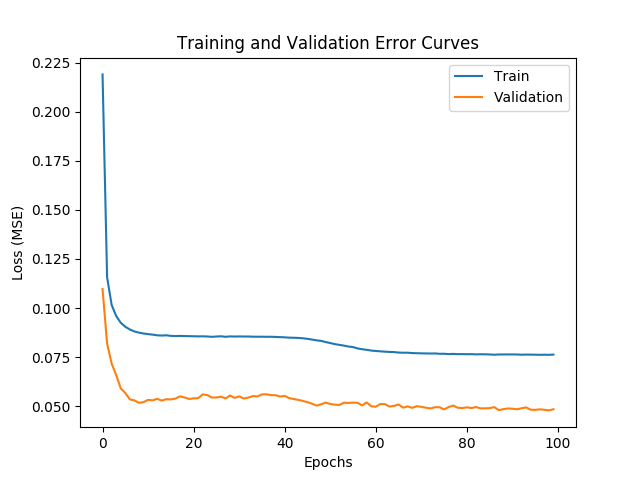

In [68]:
plot_training_error_curves(history)

Algumas funções auxiliares.

In [52]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


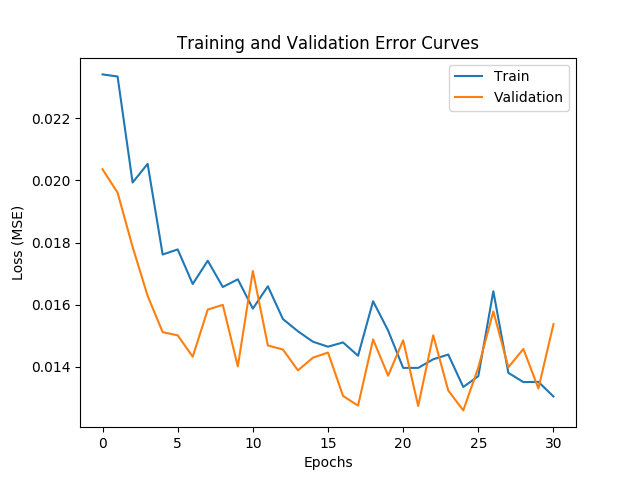

In [18]:
plot_training_error_curves(history)

In [38]:
# imprimindo a media e o desvio
historiesnp = []
for h in histories:
    historiesnp.append(h.history)
print("%.2f (+/- %.2f)" % (np.mean(historiesnp), np.std(historiesnp)))

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [19]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1891    8]
 [  28   35]]

Train Loss:       0.0134
Validation Loss:  0.0126
Accuracy:         0.9817
Recall:           0.5556
Precision:        0.8140
F1:               0.6604
AUROC:            0.8829
